In [1]:
import sys
import os
import pandas as pd
import numpy as np

from nltk.tokenize import sent_tokenize, word_tokenize 
from nltk import download
import warnings
import nltk

warnings.filterwarnings(action = 'ignore')
 
import gensim
from gensim.models import Word2Vec
from curses.ascii import isalpha
from gensim.models import KeyedVectors


from nltk.corpus import stopwords
spanish_stop_words = set(stopwords.words('spanish'))


import seaborn as sns
import matplotlib.pyplot as plt

# Import adjustText, initialize list of texts
from adjustText import adjust_text

from sklearn.manifold import TSNE

# Para calcular similitud de vectores de misma longitud
from gensim.matutils import unitvec

In [2]:
# cambiar url para leer los datos de otro subfolder con path relativo
# os.chdir('../')

# Descarga de archivos nltk necesarios para modelar, descargue todo
# download()

In [102]:
noticias = pd.read_csv('../datos/noticias.csv')

In [4]:
noticias.columns

Index(['news_id', 'news_url_absolute', 'news_init_date', 'news_final_date',
       'news_title', 'news_text_content'],
      dtype='object')

In [133]:
noticias['len_titular'] = noticias['news_title'].apply(lambda x: len(x))
noticias['len_content'] = noticias['news_text_content'].apply(lambda x: len(x))

In [6]:
noticias.sort_values('len_content',ascending=False).head(5)

news_id                                  news_url_absolute  \
1215   news14869  https://www.dclm.es/noticias/118157/las-empres...   
8548   news42765  https://www.derecho.com/boe/orden-efp7542022-d...   
11953  news56108  https://centralelectoral.ine.mx/2022/07/21/ver...   
1550   news16102  https://www.infobae.com/cultura/agenda-cultura...   
12142  news56811  https://www.dclm.es/noticias/127814/el-espacio...   

      news_init_date news_final_date  \
1215      2022-07-15      2022-07-30   
8548      2022-07-30      2022-08-14   
11953     2022-07-15      2022-07-30   
1550      2022-07-15      2022-07-30   
12142     2022-07-15      2022-07-30   

                                              news_title  \
1215   LAS EMPRESAS ANTE A LA REACTIVACION ECONOMICA ...   
8548   Orden EFP/754/2022, de 28 de julio, por la que...   
11953  Version estenografica de la Sesion Extraordina...   
1550   Guia de Arte y Cultura: semana del 22 al 29 de...   
12142  EL ESPACIO DE LA disCAPACIDAD JULIO (Castilla-...   

                                       news_text_content  len_titular  \
1215    El sector servicios elevo su facturacion un 1...           49   
8548   La Ley Organica 2/2006, de 3 de mayo, de Educa...           63   
11953  VERSION ESTENOGRAFICA PRELIMINAR DE LA SESION ...           57   
1550   ARTE Natalia Cacchiarelli, Muestra Numero Doce...           52   
12142   Por primera vez, una pareja de manchegos de A...           52   

       len_content  
1215       1557039  
8548       1441609  
11953       354396  
1550        330834  
12142       330045

# Funciones

In [7]:
def create_tokenization(x):
    data = []
    for j in word_tokenize(x,language='spanish'):
        term = j.lower()

        if term.isalpha() and not term in spanish_stop_words:
            data.append(term)
        
    # Evaluar agregar steamming para palabraes en espanol con
    # from nltk.stem import SnowballStemmer
    # spanish_stemmer = SnowballStemmer('spanish')
    # (spanish_stemmer.stem("texto_en_str"))

    return data

def document_vector(word2vec_model, doc, vocab):
    # remove out-of-vocabulary words
    doc = [word for word in doc if word in vocab]
    return np.mean(word2vec_model.wv[doc], axis=0)

# Function that will help us drop documents that have no word vectors in word2vec
def has_vector_representation(vocab, doc):
    """check if at least one word of the document is in the
    word2vec dictionary"""
    return not all(word not in vocab for word in doc)

# Filter out documents
def filter_docs(corpus, texts, condition_on_doc,vocab):
    """
    Filter corpus and texts given the function condition_on_doc which takes a doc. The document doc is kept if condition_on_doc(doc) is true.
    """
    number_of_docs = len(corpus)

    if texts is not None:
        texts = [text for (text, doc) in zip(texts, corpus)
                 if has_vector_representation(vocab,doc)]

    corpus = [doc for doc in corpus if has_vector_representation(vocab,doc)]

    print("{} docs removed".format(number_of_docs - len(corpus)))

    return (corpus, texts)

from itertools import islice

def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

def similitud(v1,v2):
    """
        Esta funcion calcula la similitud de dos vectores de misma longitud

        Inputs:
            v1: vector 1
            v2: vector 2
        
        Output: float

            Similitud de vectores

    """
    return np.dot(unitvec(v1), unitvec(v2))

In [8]:
data = noticias['news_text_content'].apply(create_tokenization)
data_titulas = noticias['news_title'].apply(create_tokenization)

In [9]:
# Create CBOW model
model1 = gensim.models.Word2Vec(data, min_count = 1,
                              vector_size = 100, window = 5)

model2 = gensim.models.Word2Vec(data, min_count = 1, vector_size = 100,
                                             window = 5, sg = 1)

In [12]:
palabra1 = 'financiero'
palabra2 = 'macroeconomia'

In [13]:
print(model1.wv.similarity(palabra1,palabra2))
print(model2.wv.similarity(palabra1,palabra2))

0.3242025
0.49237278


In [17]:
macroeconomia = model2.wv['macroeconomia']
sostenibilidad = model2.wv['sostenibilidad']
innovacion = model2.wv['innovacion']
regulaciones = model2.wv['regulaciones']
alianzas = model2.wv['alianzas']
reputacion = model2.wv['reputacion']

In [34]:
sims = model2.wv.most_similar('regulaciones', topn=20)

In [38]:
vocab = list(model2.wv.index_to_key)

In [177]:
id = 1550
# Filter the list of vectors to include only those that Word2Vec has a vector for
vector_list = [model2.wv[word] for word in data[id] if word in vocab]

# Create a list of the words corresponding to these vectors
words_filtered = [word for word in data[id] if word in vocab]

# Zip the words together with their vector representations
word_vec_zip = zip(words_filtered, vector_list)

In [178]:
# Cast to a dict so we can turn it into a DataFrame
word_vec_dict = dict(word_vec_zip)
df = pd.DataFrame.from_dict(word_vec_dict, orient='index')

In [179]:
print(df.shape)

(8879, 100)


In [182]:

# Initialize t-SNE
tsne = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 3)

# Use only 400 rows to shorten processing time
tsne_df = tsne.fit_transform(df[:400])

IndexError: index 400 is out of bounds for axis 0 with size 400

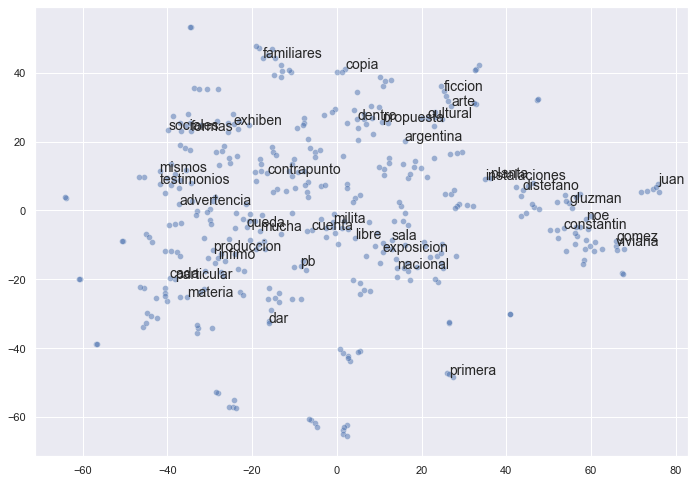

In [183]:
sns.set()
# Initialize figure
fig, ax = plt.subplots(figsize = (11.7, 8.27))
sns.scatterplot(x = tsne_df[:, 0], y = tsne_df[:, 1], alpha = 0.5)

texts = []
words_to_plot = list(np.arange(0, df.shape[0], 10))

# Append words to list
for word in words_to_plot:
    texts.append(plt.text(tsne_df[word, 0], tsne_df[word, 1], df.index[word], fontsize = 14))
    
# Plot text using adjust_text (because overlapping text is hard to read)
adjust_text(texts, force_points = 0.4, force_text = 0.4, 
            expand_points = (2,1), expand_text = (1,2),
            arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))

plt.show()

In [126]:
titles_list = list(noticias['news_text_content'])

x = []
for doc in data: # append the vector for each document
    try:
        output = document_vector(model2, doc, vocab=vocab)
    except:
        output = np.zeros(100)
    x.append(output)

# lista_val = [i for i in range(len(x)) if x[i] is None]
# lista_val_clean = [i for i in range(len(x)) if i not in lista_val]
# x = [x[i] for i in lista_val_clean]
# titles_list = [titles_list[i] for i in lista_val_clean]

X = np.array(x) # list to array

In [129]:
variables = ["macroeconomia","sostenibilidad","regulaciones","reputacion","alianzas","innovacion"]

def df_categoria_noticia(df_noticas,lista_temas,modelo,vector_promedio_noticias):

    diccionario_resultados = {}
    for variable in lista_temas:
        vector_tema = modelo.wv[variable]
        similitud_noticias = [similitud(a,vector_tema) for a in vector_promedio_noticias]
        diccionario_resultados[variable] = similitud_noticias

    resultados_temas = pd.DataFrame(diccionario_resultados)
    resultados_temas['Categoria'] = resultados_temas.idxmax(axis=1)

    df_salida = pd.concat([df_noticas,resultados_temas],axis=1)
    
    return df_salida

In [134]:
salida_categorias = df_categoria_noticia(df_noticas=noticias,lista_temas=variables,modelo=model2,vector_promedio_noticias=X)

In [135]:
salida_categorias[salida_categorias['macroeconomia']>0.6].sort_values('macroeconomia',ascending = False)

news_id                                  news_url_absolute  \
18642  news81677  https://www.perfil.com/noticias/economia/segun...   
11341  news53702  https://www.perfil.com/noticias/modo-fontevecc...   
8986   news44486  https://www.baenegocios.com/politica/Juan-Manz...   
14073  news64272  https://www.forbesargentina.com/macroeconomia/...   
11574  news54634  https://www.perfil.com/noticias/cordoba/que-es...   
...          ...                                                ...   
9213   news45284  https://dolarhoy.com/internacional/senadores-d...   
9570   news46804  https://acento.com.do/opinion/los-diversos-con...   
18178  news79983  https://m.elmostrador.cl/nueva-constitucion/20...   
4863   news28785  https://marketdata.com.py/noticias/nacionales/...   
1976   news17709  https://noticias.caracoltv.com/economia/jose-m...   

      news_init_date news_final_date  \
18642     2022-07-15      2022-07-30   
11341     2022-07-30      2022-08-14   
8986      2022-07-15      2022-07-30   
14073     2022-07-15      2022-07-30   
11574     2022-07-30      2022-08-14   
...              ...             ...   
9213      2022-07-30      2022-08-14   
9570      2022-07-15      2022-07-30   
18178     2022-07-30      2022-08-14   
4863      2022-07-15      2022-07-30   
1976      2022-07-15      2022-07-30   

                                              news_title  \
18642  Segun CAME, se necesitan medidas urgentes para...   
11341  Daniel Artana: "El kirchnerismo duro va a tene...   
8986   Juan Manzur destaco la caida del dolar blue tr...   
14073  Un nuevo y duro analisis del Financial Times s...   
11574  Que es y como piensa el think tank sub 50 del ...   
...                                                  ...   
9213   Senadores de EE.UU le piden a Biden frenar el ...   
9570   Los diversos contextos del gobierno de Luis Ab...   
18178  Influyentes economistas y pensadores de talla ...   
4863   AFD anuncia que no se encareceran sus creditos...   
1976   Jose Manuel Restrepo: "He sido un ministro de ...   

                                       news_text_content  len_titular  \
18642  Tras la confirmacion de los cambios en el Gabi...           86   
11341  En dialogo con Modo Fontevecchia ( Radio Perfi...           70   
8986   El jefe de Gabinete, Juan Manzur , afirmo este...           89   
14073  "La confianza en la Argentina se esta evaporan...           63   
11574  Entre manana y el martes comenzaran a conocers...           64   
...                                                  ...          ...   
9213    Mientras la Argentina busca desesperadamente ...           61   
9570   Tenemos razones mas que suficientes para senal...           52   
18178  Economistas y cientificos sociales, representa...           57   
4863   Mediante un comunicado, la institucion dio a c...           63   
1976   Jose Manuel Restrepo, ministro de Hacienda, ha...           77   

       len_content  macroeconomia  sostenibilidad  regulaciones  reputacion  \
18642         1649       0.693926        0.638833      0.645981    0.526174   
11341         5200       0.693786        0.589112      0.654159    0.503843   
8986          2458       0.692304        0.624605      0.606458    0.482564   
14073         2399       0.692302        0.594885      0.639234    0.529012   
11574         5645       0.692165        0.656943      0.593336    0.503016   
...            ...            ...             ...           ...         ...   
9213          2397       0.600334        0.597990      0.645175    0.495362   
9570          5771       0.600315        0.637021      0.646440    0.555267   
18178         3981       0.600142        0.688790      0.648808    0.524819   
4863          3035       0.600043        0.685247      0.637270    0.513343   
1976          5955       0.600016        0.608262      0.605219    0.541217   

       alianzas  innovacion       Categoria  
18642  0.624738    0.627192   macroeconomia  
11341  0.570024    0.567202   macroe

In [169]:
salida_categorias.groupby('Categoria').count()['news_id']

Categoria
alianzas          5824
innovacion        4706
macroeconomia      447
regulaciones      5989
reputacion         895
sostenibilidad    5516
Name: news_id, dtype: int64

In [171]:
noti_categorias = salida_categorias[variables]

corr = noti_categorias.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

In [147]:
salida_categorias['len_content'].describe()

count    2.337700e+04
mean     4.215614e+03
std      1.621316e+04
min      1.000000e+00
25%      1.759000e+03
50%      2.957000e+03
75%      4.504000e+03
max      1.557039e+06
Name: len_content, dtype: float64

In [143]:
salida_categorias['len_content'].max()

1557039

In [160]:
salida_categorias_filtro = salida_categorias[salida_categorias['len_content']<300]
print(salida_categorias.shape[0])
print(salida_categorias_filtro.shape[0])
print(salida_categorias_filtro.shape[0]/salida_categorias.shape[0])

23377
1229
0.05257304187876973


<AxesSubplot: >

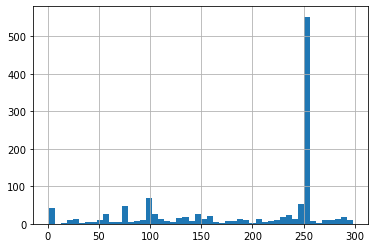

In [162]:
salida_categorias_filtro['len_content'].hist(bins=50)

In [167]:
salida_categorias_filtro[salida_categorias_filtro['len_content']==254]

news_id                                  news_url_absolute  \
25     news10112  https://www.bnamericas.com/es/noticias/ecuador...   
38     news10150  https://www.bnamericas.com/es/analisis/economi...   
59     news10222  https://www.bnamericas.com/es/noticias/dbrs-mo...   
96     news10375  https://www.bnamericas.com/es/reportajes/miner...   
194    news10711  https://www.bnamericas.com/es/noticias/interca...   
...          ...                                                ...   
22876  news98020  https://www.bnamericas.com/es/entrevistas/delf...   
23360  news99930  https://www.bnamericas.com/es/noticias/argenti...   
23361  news99932  https://www.bnamericas.com/es/noticias/producc...   
23365  news99969  https://www.bnamericas.com/es/noticias/perfora...   
23368  news99978  https://www.bnamericas.com/es/entrevistas/arge...   

      news_init_date news_final_date  \
25        2022-07-15      2022-07-30   
38        2022-07-15      2022-07-30   
59        2022-07-15      2022-07-30   
96        2022-07-15      2022-07-30   
194       2022-07-30      2022-08-14   
...              ...             ...   
22876     2022-07-30      2022-08-14   
23360     2022-07-30      2022-08-14   
23361     2022-07-30      2022-08-14   
23365     2022-07-15      2022-07-30   
23368     2022-07-15      2022-07-30   

                                              news_title  \
25        Ecuador cuenta con su primer hub de innovacion   
38     Economia de Brasil tendra mejor desempeno que ...   
59       DBRS Morningstar confirma Argentina en CCC, ...   
96       Mineras lidian con demandas por salarios y b...   
194      Intercambio comercial de Peru por TLC supera...   
...                                                  ...   
22876  Delfia: "Queremos ofrecer una curaduria inteli...   
23360  Argentina Pampa Energia esta atenta a senales ...   
23361    Produccion peruana de petroleo y gas cae tra...   
23365  Perforaciones del 2T en Mexico mostrarian tend...   
23368    Argentina alista el despegue de su sector mi...   

                                       news_text_content  len_titular  \
25      +21,000 proyectos en Latinoamerica. +28,600 e...           46   
38      +21,000 proyectos en Latinoamerica. +28,600 e...           57   
59      +21,000 proyectos en Latinoamerica. +28,600 e...           47   
96      +21,000 proyectos en Latinoamerica. +28,600 e...           47   
194     +21,000 proyectos en Latinoamerica. +28,600 e...           47   
...                                                  ...          ...   
22876   +21,000 proyectos en Latinoamerica. +28,600 e...           57   
23360   +21,000 proyectos en Latinoamerica. +28,600 e...           54   
23361   +21,000 proyectos en Latinoamerica. +28,600 e...           47   
23365   +21,000 proyectos en Latinoamerica. +28,600 e...           57   
23368   +21,000 proyectos en Latinoamerica. +28,600 e...           47   

       len_content  macroeconomia  sostenibilidad  regulaciones  reputacion  \
25             254       0.425275        0.548222      0.529702    0.396949   
38             254       0.425275        0.548222      0.529702    0.396949   
59             254       0.425275        0.548222      0.529702    0.396949   
96             254       0.425275        0.548222      0.529702    0.396949   
194            254       0.425275        0.548222      0.529702    0.396949   
...            ...            ...             ...           ...         ...   
22876          254       0.425275        0.548222      0.529702    0.396949   
23360          254       0.425275        0.548222      0.529702    0.396949   
23361          254       0.425275        0.548222      0.529702    0.396949   
23365          254       0.425275        0.548222      0.529702    0.396949   
23368          254       0.425275        0.548222      0.529702    0.396949   

       alianzas  innovacion Categoria  
25     0.565343    0.518956  alianzas  
38     0.565343    0.518956  alianzas  
59     0

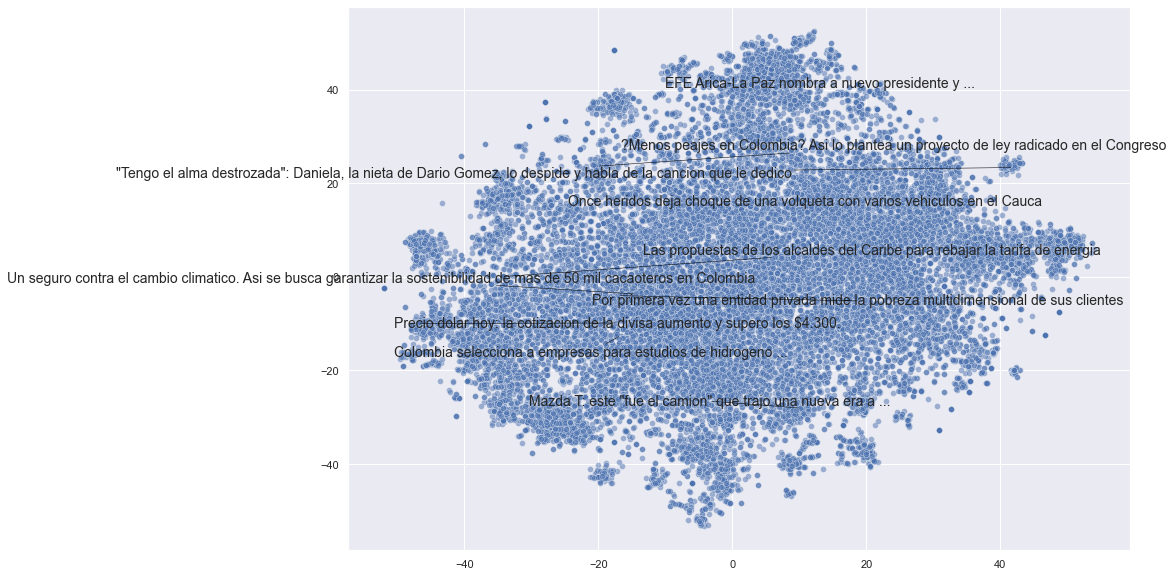

In [218]:
# Initialize t-SNE
tsne = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 100)

# Again use only 400 rows to shorten processing time
tsne_df = tsne.fit_transform(X)
fig, ax = plt.subplots(figsize = (14, 10))
sns.scatterplot(x = tsne_df[:, 0], y = tsne_df[:, 1], alpha = 0.5)

texts = []
titles_to_plot = list(np.arange(0, 800, 80)) # plots every 40th title in first 400 titles

# Append words to list
for title in titles_to_plot:
    texts.append(plt.text(tsne_df[title, 0], tsne_df[title, 1], titles_list[title], fontsize = 14))
    
# Plot text using adjust_text
adjust_text(texts, force_points = 0.4, force_text = 0.4, 
            expand_points = (2,1), expand_text = (1,2),
            arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))

plt.show()


# Prueba con Top 10 de palabra por noticia

In [11]:
content_news_list = list(noticias['news_text_content'])

top_terms = []
x_top = []

for doc in data: # append the vector for each document
    
    dict_final = nltk.FreqDist(doc)
    term = take(10,dict(dict_final))

    doc = [sub_doc for sub_doc in doc if sub_doc in term]
    
    top_terms.append(doc)
    
    try:
        output = document_vector(model2, doc, vocab=vocab)
    except:
        output = None
    x_top.append(output)
    
lista_val = [i for i in range(len(x_top)) if x_top[i] is None]
lista_val_clean = [i for i in range(len(x_top)) if i not in lista_val]

x_top = [x_top[i] for i in lista_val_clean]
top_terms = [top_terms[i] for i in lista_val_clean]

content_news_list = [content_news_list[i] for i in lista_val_clean]

content_news_list = np.array(x_top)

In [12]:
top_terms_final = [list(set(sub_doc)) for sub_doc in top_terms]

In [14]:
top_terms_text = [','.join(i) for i in top_terms_final]

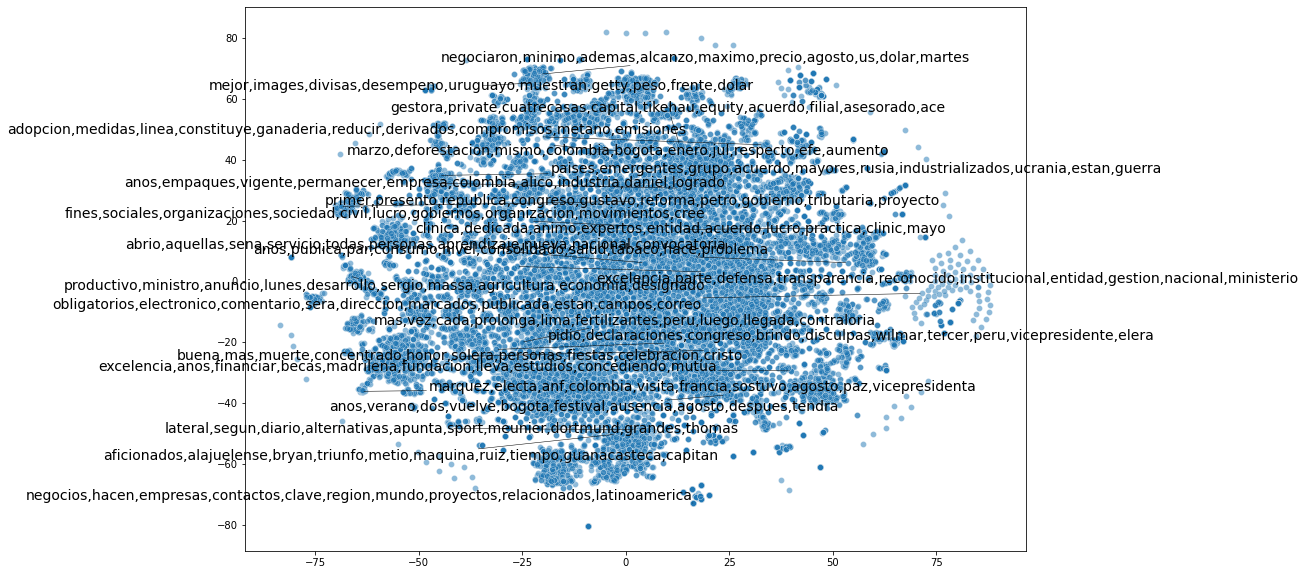

In [45]:
subset_limit = content_news_list.shape[0]

# Initialize t-SNE
tsne = TSNE(n_components = 2, init = 'random', random_state = 2022, perplexity = 40)

# Again use only 400 rows to shorten processing time
tsne_df = tsne.fit_transform(content_news_list[:subset_limit])
fig, ax = plt.subplots(figsize = (14, 10))
sns.scatterplot(x = tsne_df[:, 0], y = tsne_df[:, 1], alpha = 0.5)

texts = []
titles_to_plot = list(np.arange(0, subset_limit, 1000)) # plots every 40th title in first 400 titles

# Append words to list
for title in titles_to_plot:
    texts.append(plt.text(tsne_df[title, 0], tsne_df[title, 1], top_terms_text[title], fontsize = 14))
    
# Plot text using adjust_text
adjust_text(texts, force_points = 0.4, force_text = 0.4, 
            expand_points = (2,1), expand_text = (1,2),
            arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))

plt.show()

Text(0, 0.5, 'Inertia')

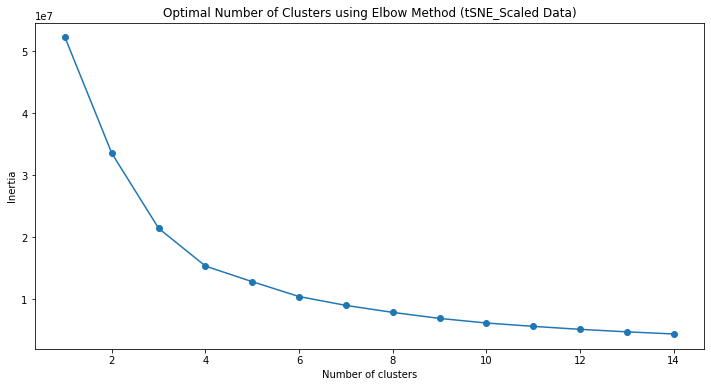

In [46]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

sse = []
k_list = range(1, 15)
for k in k_list:
    km = KMeans(n_clusters=k)
    km.fit(tsne_df)
    sse.append([k, km.inertia_])
    
tsne_results_scale = pd.DataFrame({'Cluster': range(1,15), 'SSE': sse})
plt.figure(figsize=(12,6))
plt.plot(pd.DataFrame(sse)[0], pd.DataFrame(sse)[1], marker='o')
plt.title('Optimal Number of Clusters using Elbow Method (tSNE_Scaled Data)')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

In [53]:
from sklearn.metrics import silhouette_score

kmeans_tsne_scale = KMeans(n_clusters=6, n_init=100, max_iter=400, init='k-means++', random_state=42).fit(tsne_df)
print('KMeans tSNE Scaled Silhouette Score: {}'.format(silhouette_score(tsne_df, kmeans_tsne_scale.labels_, metric='euclidean')))
labels_tsne_scale = kmeans_tsne_scale.labels_

KMeans tSNE Scaled Silhouette Score: 0.3589571416378021


In [54]:
clusters_tsne_scale = pd.concat([pd.DataFrame(tsne_df), pd.DataFrame({'tsne_clusters':labels_tsne_scale})], axis=1)

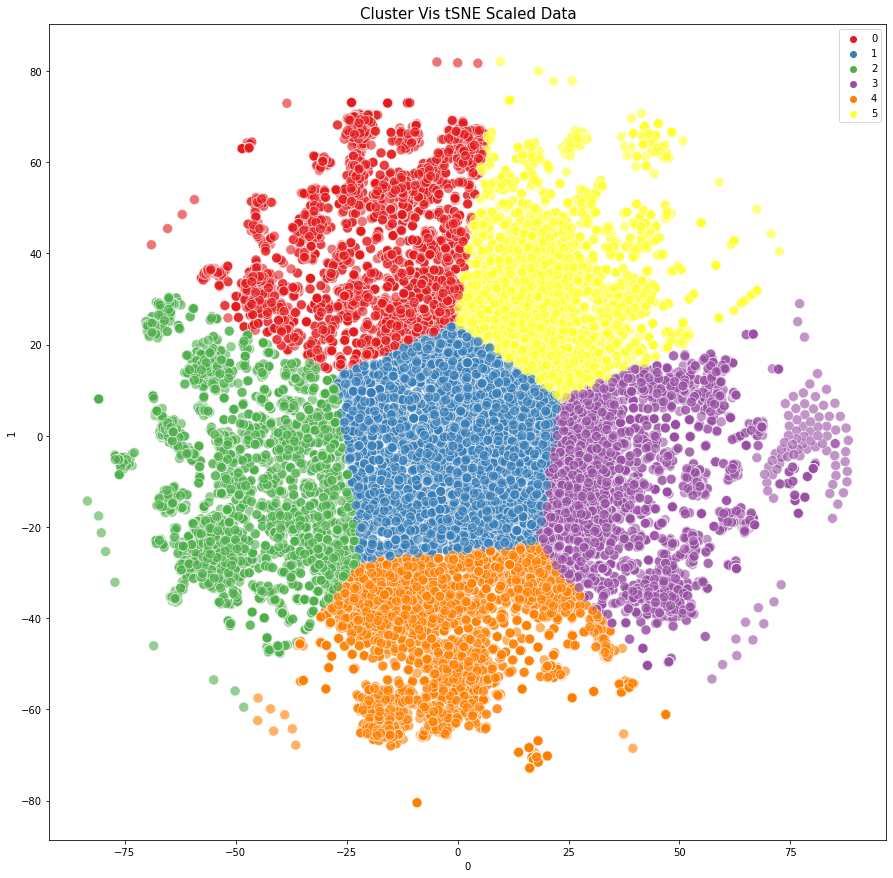

In [55]:
plt.figure(figsize = (15,15))
sns.scatterplot(x = clusters_tsne_scale.iloc[:,0],y = clusters_tsne_scale.iloc[:,1],hue=labels_tsne_scale, palette='Set1', s=100, alpha=0.6).set_title('Cluster Vis tSNE Scaled Data', fontsize=15)
plt.legend()
plt.show()

In [57]:
clusters_tsne_scale['top_ten_terms'] = top_terms_text

In [59]:
clusters_tsne_scale.groupby('tsne_clusters').count()['top_ten_terms']

tsne_clusters
0    3570
1    4291
2    3902
3    3753
4    4098
5    3714
Name: top_ten_terms, dtype: int64

In [71]:
a = clusters_tsne_scale[clusters_tsne_scale['tsne_clusters']==2].copy()
for i in a.loc[:,'top_ten_terms']:
    print(i)

mas,financieras,x,operaciones,impuesto,permanente,temporal,asi,gravaron,ocurrio
electo,serias,empalme,dio,gustavo,petro,presidente,equipo,gobierno,alertas
tarde,base,aebu,publicos,reunion,privados,llevara,definir,cabo,sindicatos
describir,momento,inusual,posesion,podria,cultural,sera,presidente,asi,oficial
mostro,idea,martes,fiscal,bajar,decidida,ministra,transmitir,deficit,intento
electo,avanzando,presidencial,posesion,gustavo,petro,presidente,continuan,preparativos,tendra
bancos,ladron,miami,supervisada,tras,robo,encontraba,jul,efe,libertad
montevideo,bancarios,uruguay,trabajadores,ago,asociacion,afiliados,banca,efe,privada
colombiano,retos,destaco,ignacio,grupo,moderador,presidente,gaitan,espacio,grandes
monte,continuaran,aebu,radio,juan,dijo,fernandez,dias,carlo,dirigente
primer,comienza,anos,izquierda,mandato,gustavo,colombia,petro,cuatro,presidente
primer,vivio,dia,posesiono,colombia,gustavo,petro,historico,presidente,mandatario
primer,izquierda,domingo,gustavo,colombia,petro,gob